CS4001/4042 Assignment 1, Part B, Q3
---

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [35]:
!pip install captum

You should consider upgrading via the '/Users/advait/Desktop/gitpositories/SC4001-Assignment/env/bin/python -m pip install --upgrade pip' command.


In [36]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

> First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [37]:
# TODO: Enter your code here

df = pd.read_csv('hdb_price_prediction.csv')

train_data = df[df['year'] <= 2019]
validation_data = df[df['year'] == 2020]
test_data = df[df['year'] == 2021]

# Drop all categorical features
target = ['resale_price']
continuous_cols = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
categorical_cols = ['month', 'town', 'flat_model_type', 'storey_range']

train_data = train_data[continuous_cols + target]
validation_data = validation_data[continuous_cols + target]
test_data = test_data[continuous_cols + target]

> Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [38]:
batch_size = 64
num_epochs = 100
learning_rate = 0.001
size_hidden1 = 5
size_hidden2 = 5
size_hidden3 = 5
no_labels = 1

In [39]:
# TODO: Enter your code here

from torch.utils.data import DataLoader, TensorDataset

# Convert dataframes to PyTorch tensors
X_train = torch.tensor(train_data[continuous_cols].values).float()
y_train = torch.tensor(train_data[target].values).view(-1, 1).float()

X_val = torch.tensor(validation_data[continuous_cols].values).float()
y_val = torch.tensor(validation_data[target].values).view(-1, 1).float()

X_test = torch.tensor(test_data[continuous_cols].values).float()
y_test = torch.tensor(test_data[target].values).view(-1, 1).float()

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [40]:
class HDBResaleModel(nn.Module):
    def __init__(self, no_features, no_hidden1, no_hidden2, no_hidden3, no_labels):
        super().__init__()
        self.lin1 = nn.Linear(no_features, no_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(no_hidden1, no_hidden2)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(no_hidden2, no_hidden3)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(no_hidden3, no_labels)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))

In [41]:
model = HDBResaleModel(X_train.shape[1], size_hidden1, size_hidden2, size_hidden3, no_labels)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
def train(model_inp, num_epochs, optimizer, loss_fn, dataloader):
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in dataloader:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = loss_fn(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

train(model, num_epochs, optimizer, criterion, train_loader)

Epoch [1]/[100] running accumulative loss across all batches: 209603982770176.000
Epoch [21]/[100] running accumulative loss across all batches: 6317572945152.000
Epoch [41]/[100] running accumulative loss across all batches: 5460657758464.000
Epoch [61]/[100] running accumulative loss across all batches: 4775755073280.000
Epoch [81]/[100] running accumulative loss across all batches: 4594865263744.000


In [43]:
# Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation

sal = Saliency(model)
ixg = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

sal_attr_test = sal.attribute(X_test[:1000])
ixg_attr_test = ixg.attribute(X_test[:1000])
ig_attr_test = ig.attribute(X_test[:1000], n_steps=50)

# Entire training set used for the distribution of baselines

gs_attr_test = gs.attribute(X_test[:1000], X_train)
fa_attr_test = fa.attribute(X_test[:1000])

# sal_attr_test = sal.attribute(X_test)
# ixg_attr_test = ixg.attribute(X_test)
# ig_attr_test = ig.attribute(X_test, n_steps=50)
# gs_attr_test = gs.attribute(X_test, X_train)
# fa_attr_test = fa.attribute(X_test)

/Users/advait/Desktop/gitpositories/SC4001-Assignment/env/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


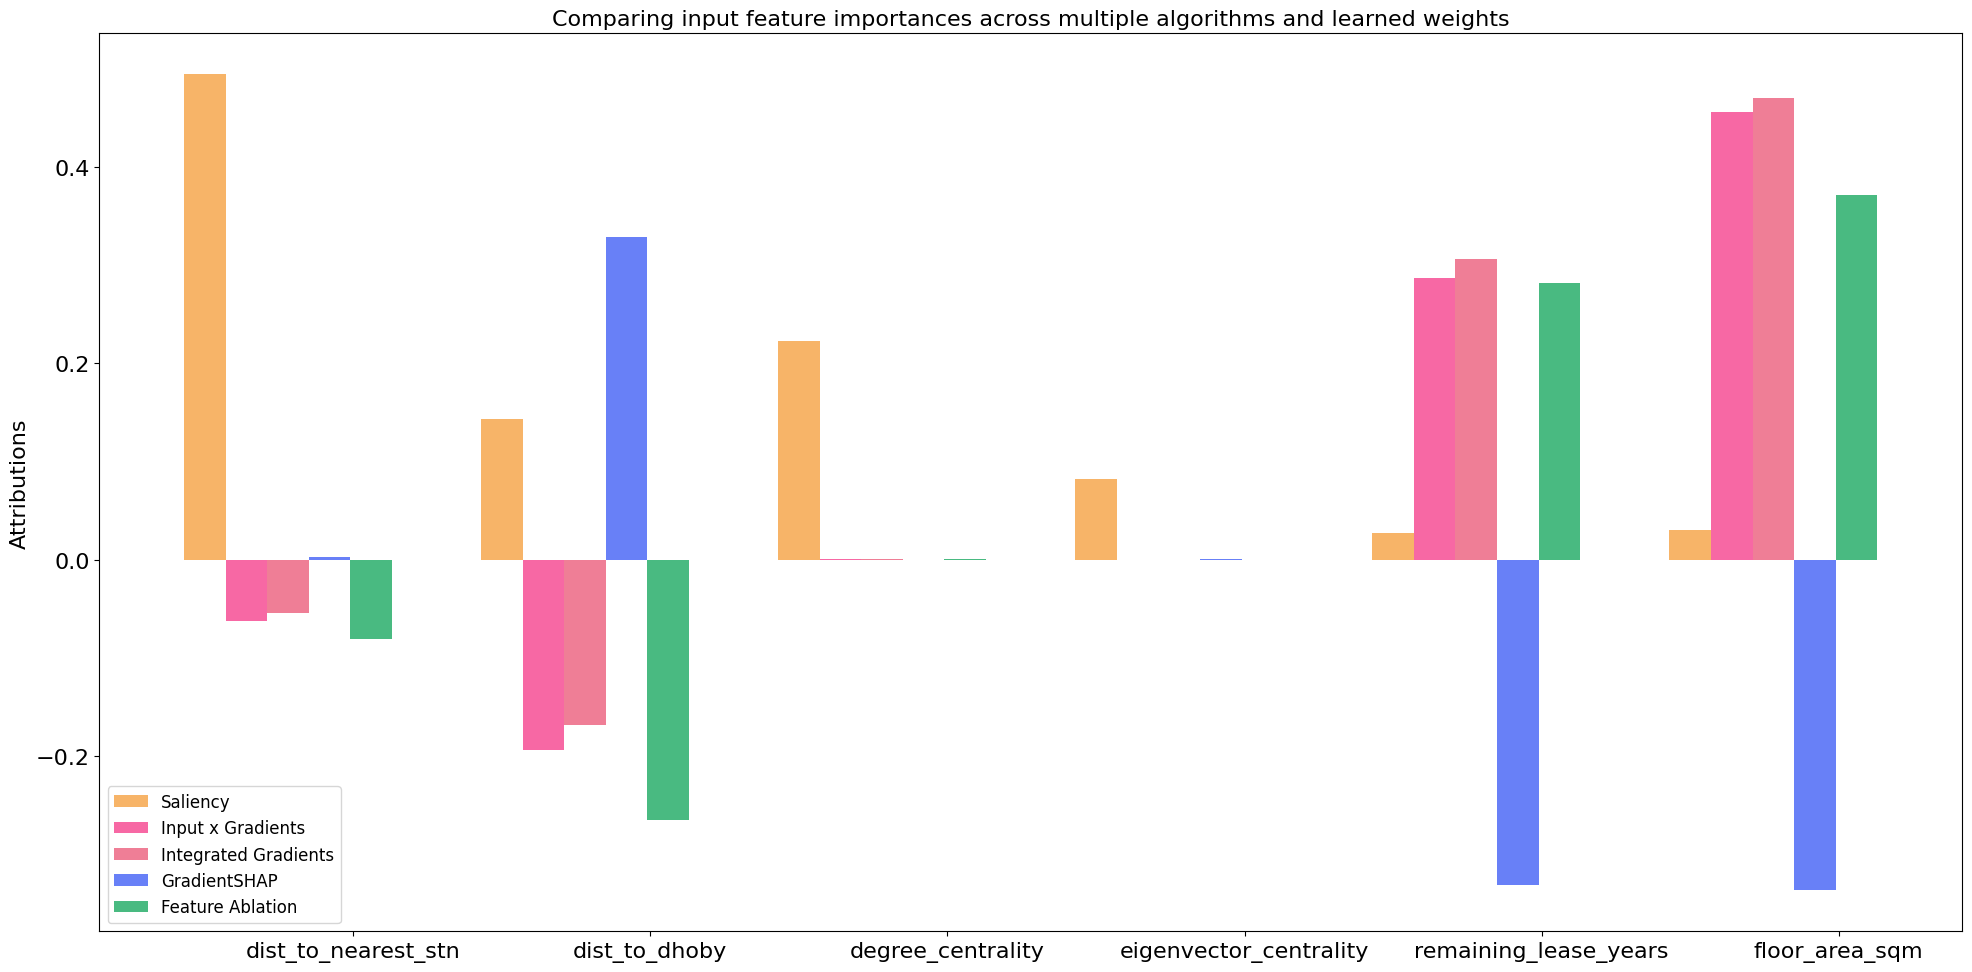

In [44]:
import matplotlib.pyplot as plt

feature_names = train_data.drop(target, axis=1).columns

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

sal_attr_test_sum = sal_attr_test.detach().numpy().sum(0)
sal_attr_test_norm_sum = sal_attr_test_sum / np.linalg.norm(sal_attr_test_sum, ord=1)

ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

width = 0.14
legends = ['Saliency','Input x Gradients', 'Integrated Gradients', 'GradientSHAP', 'Feature Ablation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, sal_attr_test_norm_sum, width, align='center', alpha=0.8, color='#f5a142')
ax.bar(x_axis_data + width, ixg_attr_test_norm_sum, width, align='center', alpha=0.8, color='#f5428d')
ax.bar(x_axis_data + 2 * width, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

> Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_train = torch.tensor(scaled_X_train).float() # fixed typo

scaled_X_val = scaler.transform(X_val)
scaled_X_val = torch.tensor(scaled_X_val).float()

scaled_X_test = scaler.transform(X_test)
scaled_X_test = torch.tensor(scaled_X_test).float()

# Create data loaders
train_dataset = TensorDataset(scaled_X_train, y_train)
val_dataset = TensorDataset(scaled_X_val, y_val)
test_dataset = TensorDataset(scaled_X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = HDBResaleModel(scaled_X_train.shape[1], size_hidden1, size_hidden2, size_hidden3, no_labels)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(model, num_epochs, optimizer, criterion, train_loader)

Epoch [1]/[100] running accumulative loss across all batches: 216361233580032.000
Epoch [21]/[100] running accumulative loss across all batches: 4329810764416.000
Epoch [41]/[100] running accumulative loss across all batches: 3780589538432.000
Epoch [61]/[100] running accumulative loss across all batches: 3658540043904.000
Epoch [81]/[100] running accumulative loss across all batches: 3489850261120.000


In [46]:
sal = Saliency(model)
ixg = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

sal_attr_test = sal.attribute(X_test[:1000])
ixg_attr_test = ixg.attribute(X_test[:1000])
ig_attr_test = ig.attribute(X_test[:1000], n_steps=50)
gs_attr_test = gs.attribute(X_test[:1000], X_train)
fa_attr_test = fa.attribute(X_test[:1000])

/Users/advait/Desktop/gitpositories/SC4001-Assignment/env/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


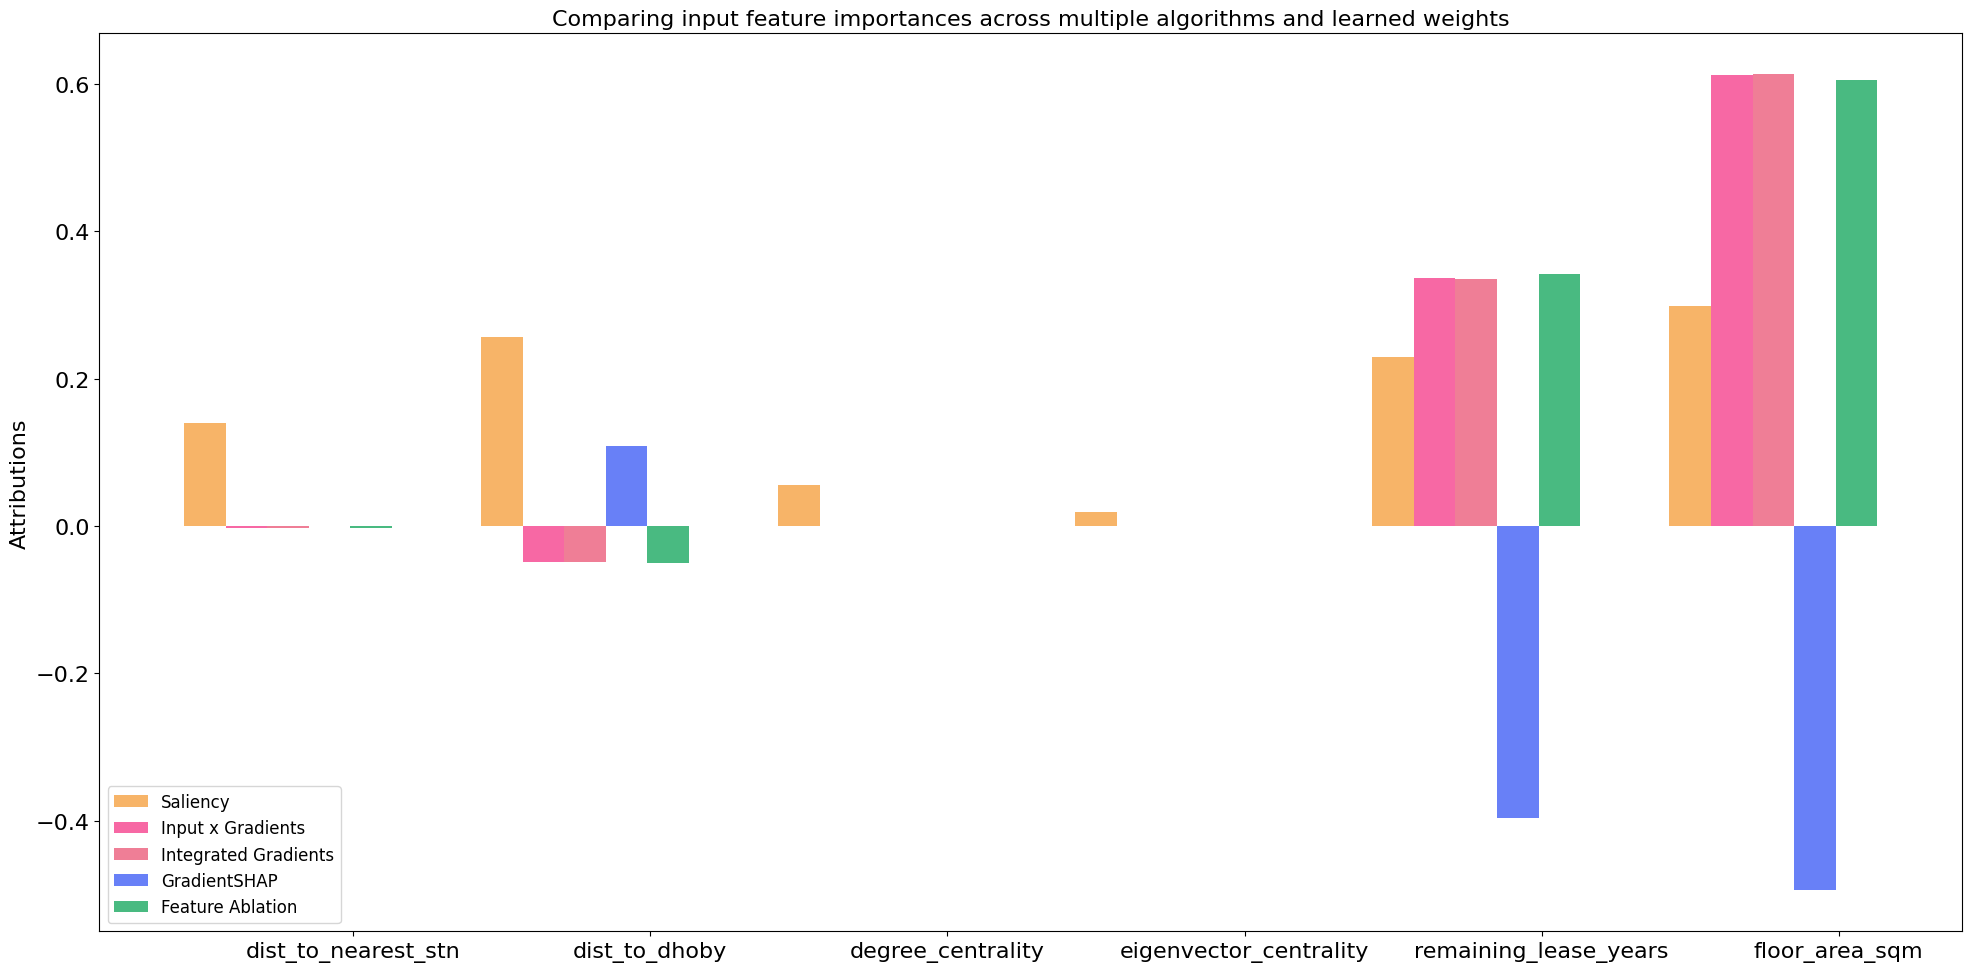

In [47]:
import matplotlib.pyplot as plt

feature_names = train_data.drop(target, axis=1).columns

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

sal_attr_test_sum = sal_attr_test.detach().numpy().sum(0)
sal_attr_test_norm_sum = sal_attr_test_sum / np.linalg.norm(sal_attr_test_sum, ord=1)

ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

width = 0.14
legends = ['Saliency','Input x Gradients', 'Integrated Gradients', 'GradientSHAP', 'Feature Ablation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, sal_attr_test_norm_sum, width, align='center', alpha=0.8, color='#f5a142')
ax.bar(x_axis_data + width, ixg_attr_test_norm_sum, width, align='center', alpha=0.8, color='#f5428d')
ax.bar(x_axis_data + 2 * width, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

"State your observations with respect to GradientShap and explain why it has occurred."

After standardising the features using StandardScaler, the attribution scores returned for GradientSHAP remain directionally the same. However, the score for 'dist_to_dhoby' decreased in magnitude, while the scores for 'remaining_lease_years' and 'floor_area_sqm' increased. 

GradientSHAP is calculated with a baseline of the training distribution, while the other attribution scores have a default baseline of zero. By standardising the features, we change this distribution as StandardScaler changes the distribution such that it has a standard deviation of 1. Hence as distribution changes, the baseline for GradientSHAP changes too, hence affecting its attribution scores more. 

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

> Why did Saliency produce scores similar to IG?


Saliency does not produce scores similar to IG consistently across different features for both the models train on the scaled and non-scaled datasets. 

Saliency returns just the gradient of the output with respect to the input, while Integrated Gradients returns the accumulation of gradients with respect to inputs along a path from the baseline to the input, multiplied by the difference between the baseline and input.

For Saliency and IG to be similar, the gradients must be very consistent along the baseline to the input, such that integral of the gradients that is taken by Integrated Gradients does not differ much from the direct gradients computed for Saliency. 

In our case, with baseline set as zero, it is possible that this is far from the input distribution of a some features. Thus resulting in largely varying attribution scores produced by Saliency and IG. However, with a marge larger data set this may not be the case. 

Interestingly, the discrepancy between Saliency and IG Values is reduced after scaling. This could be due to the standardisation of the input distribution helping to bring the baseline closer to it.

Another possible reason is that non-linear relations captured by IG could also add to its score, causing a discrepancy from Saliency Values. For example, resale price could increase linearly with floor area, but more than proportionately with respect to distance to MRT.


> Why did Input x Gradients give the same attribution scores as IG?


Input x Gradients compute the gradient of the mode output with respect to each input feature and multiplying by the input values. While Integrated Gradients gets the importance scores by accumulating gradients between the baseline value and the current input. 

We see that the attribution scores given by both are very similar but not the same for both the models. This is likely due to the difference between the baseline and input being small enough such that there may not be enough variation between gradients for integral calculated for Integrated Gradients to make a significant difference. 

This effect is further enhanced after the data set is scaled, as observed in the graphs, where IxG and IG go from similar, to almost the same after scaling.